# Project For P2 - Introduction To Data Analysis

Author - Marcelo de Sena Lacerda

## Introduction
This project seeks to analyze [Lahman’s Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/) from 1871 to 2015. I am going to analyze and try to understand the relationship between player salaries and receiving awards.

## The data set

In seanlahman.com several options for acquiring the data set are given(access, CSV and sql), for this project it was chosen the CSV files since they can be easily imported with the [pandas](http://pandas.pydata.org/) library.

The data set comes in a zip bundle that contains several CSV files(referred also as tables through the rest of this project). Each table relates to a set of statistics about pitching, hitting, and fielding statistics for american baseball games from 1871 through 2015. The layout of the contents of CSV files(the order of the columns) and the detailed description of each column can be found in the [data set readme](http://seanlahman.com/files/database/readme2014.txt).


For this project I'm going to analyze the relationship between player salary and having an award. For those two factors, having an award and yearly salary several questions can be raised:

1. Do salaries increase when a player receives an award?
2. Do salaries increase before a player receives an award?
3. Do salaries keep increasing the more awards a player gets?
4. By how much is a salary expected to increase after an award?
5. Do players that receive awards tend to play in the same teams?
6. Is there an award-winning player creep in teams?(Are some teams collecting award-winning players and not hiring other players)?

Since the time to analyze that data set is limited the time it takes to answer any of those questions is greater than I initially expected I tried to focus on only the first question.


## The preliminary analysis

Now, before proceeding I must first do a bit of a bootstrap, import the libraries that I'm going to use and load the data set.

In [1]:
import pandas as pd, os.path, numpy as np, humanize
%matplotlib inline
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
salaries_table = pd.read_csv(os.path.join('csvs', 'Salaries.csv'))
awards_table = pd.read_csv(os.path.join('csvs', 'AwardsPlayers.csv'))

Next I should take a look to see if everything is alright. It's also important to know whether there are some null fields in our tables as they may influence our study.

In [2]:
print 'Salaries table'
print salaries_table.head()
print "Salaries's empty values"
print salaries_table.isnull().sum()
print 'Awards table'
print awards_table.head()
print "Awards's empty values"
print awards_table.isnull().sum()

Salaries table
   yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000
3    1985    ATL   NL   campri01  633333
4    1985    ATL   NL  ceronri01  625000
Salaries's empty values
yearID      0
teamID      0
lgID        0
playerID    0
salary      0
dtype: int64
Awards table
    playerID                awardID  yearID lgID  tie notes
0   bondto01  Pitching Triple Crown    1877   NL  NaN   NaN
1  hinespa01           Triple Crown    1878   NL  NaN   NaN
2  heckegu01  Pitching Triple Crown    1884   AA  NaN   NaN
3  radboch01  Pitching Triple Crown    1884   NL  NaN   NaN
4  oneilti01           Triple Crown    1887   AA  NaN   NaN
Awards's empty values
playerID       0
awardID        0
yearID         0
lgID           0
tie         6033
notes       1430
dtype: int64


Everything seems to be in order, there are two fields with a significant number of empty values in the awards table, but we are not interested in the information that some awards are tied with other players, nor we care about the notes about the awards.

Next I should gather some basic statistics about the salaries.

In [3]:
ksalary = salaries_table['salary']/1000
ksalary.describe().apply(lambda x: humanize.intcomma(int(x)))

count    25,575
mean      2,008
std       3,315
min           0
25%         275
50%         550
75%       2,250
max      33,000
Name: salary, dtype: object

Here we can see that more than half of all salaries are below 1 million but the mean is 2 million, this must mean that we have few players that win far above 1 million that are pulling the mean up, the standard deviation of 3 million is further evidence of an uneven distribution.

In [4]:
print 'Year with most awards:', int(awards_table['yearID'].mode())
print 'Median of the years:', int(awards_table['yearID'].median())

Year with most awards: 2007
Median of the years: 1974


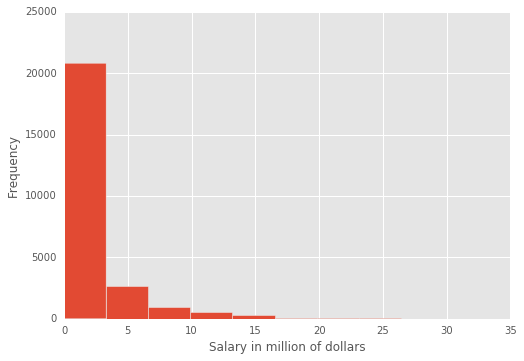

In [5]:
plt.figure()
axes = (ksalary/1000).hist()
axes.set_xlabel("Salary in million of dollars")
axes.set_ylabel("Frequency")

This chart confirms our suspicions that the salary distribution is positively skewed and very uneven. But there seems to be some data points too small to be seen on the far right of the histogram. Let's try to see them on a box plot.

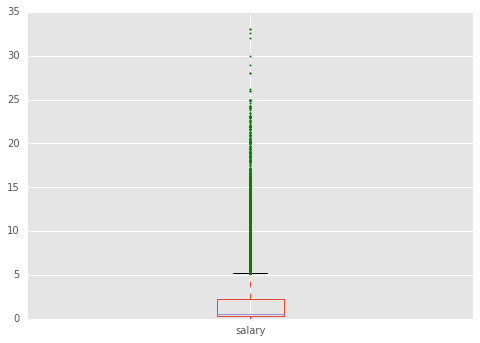

In [6]:
axes = (ksalary/1000).plot.box(flierprops = dict(marker='o', markerfacecolor='green', markersize=2,
                  linestyle='none'))

There is a lot of outliers in the plot that explain how our standard deviation is so big and how our mean is almost 4 times bigger than our median.

We should also take a look at our awards table, one interesting question to ask is how are the awards distributed over time, in other words, do the number of awards granted vary as time passes?

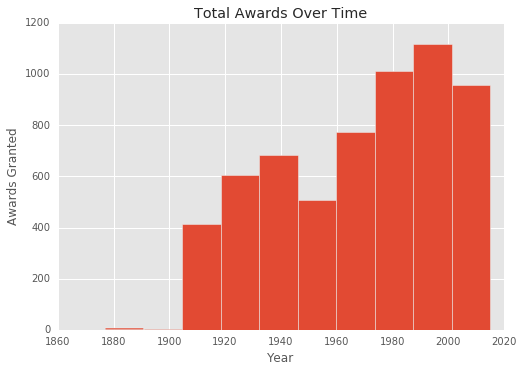

In [7]:
awards_table[['yearID']].hist()
plt.xlabel('Year')
plt.ylabel('Awards Granted')
plt.title('Total Awards Over Time')

plt.show()

It seems like awards granted increase with time.

## Analyzing the relationship between player salaries and receiving an award

The question I was set to answer is do salaries increase with awards, but soon after starting to investigating the issue I realized that I cannot answer the question before asking if salaries increase regardless, in other words, is there inflation in the salaries? To answer that question I plotted the average player salaries over time.

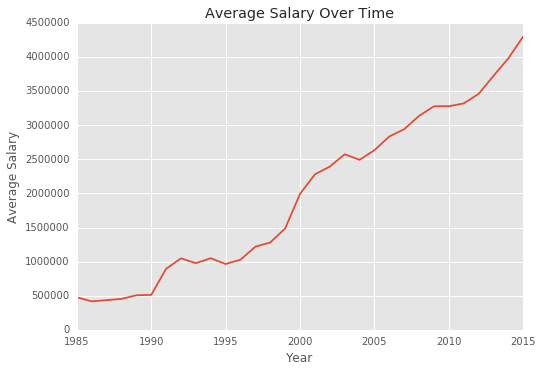

In [8]:
average_mean_salaries = salaries_table.groupby('yearID')['salary'].mean()
axes = average_mean_salaries.plot(title='Average Salary Over Time')
axes.set_xlabel('Year')
axes.set_ylabel('Average Salary')

From that plot I suspected that I couldn't use a salary delta(salary after an award - salary before an award) to test whether salaries increase because the deltas could be highly influenced for the inflation of that year. I could try to isolate the effect of inflation but doing so would amplify the scope of this project greatly.

Instead, as suggested on the [forums](https://discussions.udacity.com/t/testing-for-correlation-between-the-salaries-of-baseball-players-and-awards-won/185580/2?u=msl09) I decided to analyze if the average salary for players that won an award is greater than it is for players that didn't win an award and compare that with the average salary for players who didn't win an award.

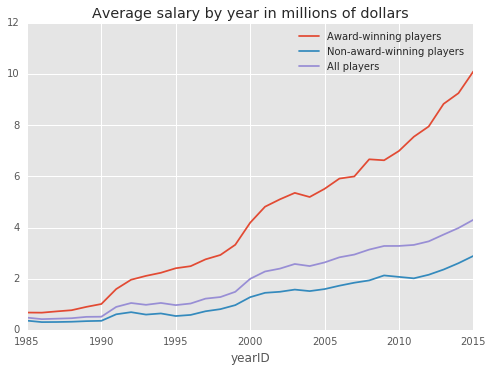

In [12]:
winners = salaries_table[salaries_table.playerID.isin(awards_table['playerID'])]
nonwinners = salaries_table[~salaries_table.playerID.isin(awards_table['playerID'])]

result = pd.DataFrame()
win = winners.groupby('yearID')['salary']
result['Award-winning players'] = win.mean()
nwin = nonwinners.groupby('yearID')['salary']
result['Non-award-winning players'] = nwin.mean()
result['All players'] = average_mean_salaries
result = result / 1000000
result.plot(title='Average salary by year in millions of dollars')

From the chart, although there seems to be some influence of inflation on salaries, it seems like having an award is a much better predictor of better salaries.

## Testing for correlation

In order to improve our understanding of the relationship of those variables, I'm now going to perform a statistical test to know whether the award-winning players mean salaries are significantly different from non-award-winning players on the population.

### Prerrogatives

Before considering the kind of statistical tests avaliable for us it's important to know what kind of variables we are dealing with, their distributions, their relationships and the overall the relationship of the data set we are analyzing and the entire population.

Our dependent variable, the mean salary is a continuous quantitiative variable, it's distribution is positivelly skewed.

The "awardwinningness" of a player is a, categorical, boolean variable, either a player won an award or not. Since in this test having or not an award is the independent variable, we are only going to use it to divide the sample of salaries into two groups, in other words we are not going to calculate a correlation coeficcient of between the two variables.

We must also consider wether the two grups are independent, having one group influencing another could mean that we can't use an independent samples test. Unfortunately there is no way for me to know whether if the average salary for non-award-winning players in one year influences the salary of award-winning players during their next contract renovation To simplify my calculations I'm going to assume that the groups are completelly independent. Possibly only a rigorous test taking in account the contract renovations for each player could give us confidence that the two groups are independent or not.

Finally there are matters that we must consider regarding whether the data comprehends the complete set of salaries for all american baseball players, in other words is this data set the entire population? One simple test can give us a hint in that regard:

In [10]:
players_that_received_award = awards_table['playerID']
players_that_received_salary = salaries_table['playerID']
no = players_that_received_award[~players_that_received_salary.isin(players_that_received_award)]
print 'Number of players that received an award but received no salaries:', len(no.unique())

Number of players that received an award but received no salaries: 1174


The fact that there are players that appear on the awards table but not in the salaries table suggests that there is data missing from Sean Lahman's database. It's only logical that in a set of data that was supplied by volunteers and enthusiasts there would be data missing. Considering that, I'm going to treat the data being studied as a sample.

Treating our data set as a sample makes it necessary for me to consider whether there is any bias on the sample. Like with the problem of possible correlation between groups, I'm going to take a speculative approach: It's unlikely that there was any bias in the sampling of the data set since the creation of the data set was a collective effort from many fans and researchers. I believe that any bias that could have happened(like incorrect data or omissions) with the contribution of one person would be corrected by the contributions of the other volunteers. 

### Choosing the statistical method

The information collected previously should help us to know what method would be the most appropriate one. I'm going to be using this [listing](http://www.ats.ucla.edu/stat/mult_pkg/whatstat/default.htm) as a guide. From the fact that we have one dependent variable and one independent variable, the independent variable is both non-normal and continuous, we know must choose either the Wilcoxon signed-rank or Mann-Whitney test. Since the two groups, award-winning and non-award-winning, are not paired samples, because there is no logical way to pair one award-winning player with another non-award-winning player, we narrow down to the Mann–Whitney U test.

### Executing the test

We are going to perform an independent samples t-test to check for differences between the salary distributions.

H-null: The distributions for award-winning players and non-award-winning players is the same in the population.

H1: The distributions are different in the population.

For α = .05

Since our sample sizes are both greater than 10 we use the [continuity correction method](http://ictedusrv.cumbria.ac.uk/maths/SecMaths/U4/page_80.htm).

In [11]:
import scipy.stats

winners_sample = winners['salary']
nonwinners_sample = nonwinners['salary']

result = scipy.stats.mannwhitneyu(winners_sample, nonwinners_sample, use_continuity=True)
print 'p-value:', result.pvalue, 'u-statistic:', result.statistic

p-value: 0.0 u-statistic: 33541382.5


### Results

With p-value < .5 we reject the null hypothesis. So we can tell that the distributions are also likely to be different in the population. Since the difference in the sample is due to the mean salary of award-winning players being, on average, higher than other players we can also expect that salaries in the population show a similar pattern. 

## Conclusion

In this project we were able to analyze the data sets of salaries and awards, we were able to see graphically the difference in average salaries between players that won an award and players that did not and test for whether the differences in the salaries distributions are likely due to chance.

It's important to notice, though, that this analysis is limited in scope. This analysis did not measure the degree of correlation between receiving an award and having better salaries, nor did it explain whether having an award causes higher salaries or if award-winning players receive higher salaries even before receiving an award. To do so we would need to do more statistical tests to measure the impact of awards on salary and compare player salaries before and after they receive an award(possibly year by year to minimize the impact of inflation). All of that would extend this project a lot more, so, because of that, this is as far as this study will go.